In [1]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from scribe_classifier.data.canada import AllCodes, TitleSet, SimpleModel
from scribe_classifier.data.canada.NOCdb.models.neural_networks.combined_models import CombinedModels
from sklearn import metrics
import numpy as np

Using TensorFlow backend.


In [2]:
mdl_strs = dict()
for target_level in range(1,4):
    level_mdl_strs = dict()
    level_mdl_strs['sgd'] = 'source_data/pickles/canada/trained_models/simple.lvl%d.sgdsv.P' % target_level
    level_mdl_strs['bayes'] = 'source_data/pickles/canada/trained_models/simple.lvl%d.bayes.P' % target_level
    level_mdl_strs['ann'] = 'source_data/pickles/canada/trained_models/ann/neural_net_level%d.frozen.P' % target_level
    mdl_strs[target_level]= level_mdl_strs

In [3]:
all_codes = AllCodes.load_from_pickle("./source_data/pickles/canada/tidy_sets/all_codes.P", is_path=True)
emptyset_label = "NA"
all_codes.add_emptyset()
test = TitleSet.load_from_pickle('source_data/pickles/canada/test_sets/test.set.lvl4.P', is_path=True)
test = test.copy_and_append_empty_string_class(label=emptyset_label, prop_records=0.25)
train = TitleSet.load_from_pickle('source_data/pickles/canada/test_sets/train.set.lvl4.P', is_path=True)
train = train.copy_and_append_empty_string_class(label=emptyset_label, prop_records=0.25)
split, valid = train.split_data_train_test(target_level=4, test_split=0.25)
del train
del split
train = None
split = None
acv = dict()
for i in range(1,4):
    acv[i] = all_codes.get_codes_for_level(target_level=i)

In [4]:
def prep_level(target_level):
    mdl = CombinedModels('source_data/pickles/canada/tidy_sets/all_codes.P',
                         mdl_strs[1],
                         mdl_strs[2],
                         mdl_strs[3],
                         target_level=target_level)
    valid_preds = mdl.predict(valid.get_title_vec())
    test_preds = mdl.predict(test.get_title_vec())
    valid_y = valid.get_code_vec(target_level=target_level)
    test_y = test.get_code_vec(target_level=target_level)
    
    return valid_preds, valid_y, test_preds, test_y, mdl

def eval_level(vp, vy, tp, ty, target_level):
    valid_eval = list(metrics.precision_recall_fscore_support(vy, vp, labels=acv[target_level], average=None))
    test_eval = list(metrics.precision_recall_fscore_support(ty, tp, labels=acv[target_level], average=None))
    return valid_eval, test_eval, metrics.accuracy_score(vy, vp), metrics.accuracy_score(ty, tp)

#std error for error bars std_dev / sqrt(samp_size)
def get_prec(evals, acv):
    df = pd.DataFrame()
    df['Class'] = pd.Series(acv)
    df['Precision'] = pd.Series(evals[0])
    avg = df['Precision'].mean()
    std_err = df['Precision'].std() / np.sqrt(len(df['Class']))
    return avg, std_err

def get_recall(evals, acv):
    df = pd.DataFrame()
    df['Class'] = pd.Series(acv)
    df['Recall'] = pd.Series(evals[1])
    avg = df['Recall'].mean()
    std_err = df['Recall'].std() / np.sqrt(len(df['Class']))
    return avg, std_err

def get_f1(evals, acv):
    df = pd.DataFrame()
    df['Class'] = pd.Series(acv)
    df['F1 Score'] = pd.Series(evals[2])
    avg = df['F1 Score'].mean()
    std_err = df['F1 Score'].std() / np.sqrt(len(df['Class']))
    return avg, std_err

def plot_prec(evals, acv):
    avgs = []
    std_errs = []
    levels = []
    for i in range(1,4):
        avg, std_err = get_prec(evals[i], acv[i])
        avgs.append(avg)
        std_errs.append(std_err)
        levels.append(i)
    df = pd.DataFrame()
    df['Class Level'] = pd.Series(levels)
    df['Avg Precision'] = pd.Series(avgs)
    df['Std Err Precision'] = pd.Series(std_errs)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_autoscaley_on(False)
    ax.set_ylim([0,1])
    sn.barplot(data=df, x='Class Level', y='Avg Precision', ax=ax, yerr=df['Std Err Precision'])
    
def plot_recall(evals, acv):
    avgs = []
    std_errs = []
    levels = []
    for i in range(1,4):
        avg, std_err = get_recall(evals[i], acv[i])
        avgs.append(avg)
        std_errs.append(std_err)
        levels.append(i)
    df = pd.DataFrame()
    df['Class Level'] = pd.Series(levels)
    df['Avg Recall'] = pd.Series(avgs)
    df['Std Err Recall'] = pd.Series(std_errs)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_autoscaley_on(False)
    ax.set_ylim([0,1])
    sn.barplot(data=df, x='Class Level', y='Avg Recall', ax=ax, yerr=df['Std Err Recall'])
    
def plot_f1(evals, acv):
    avgs = []
    std_errs = []
    levels = []
    for i in range(1,4):
        avg, std_err = get_f1(evals[i], acv[i])
        avgs.append(avg)
        std_errs.append(std_err)
        levels.append(i)
    df = pd.DataFrame()
    df['Class Level'] = pd.Series(levels)
    df['Avg F1 Score'] = pd.Series(avgs)
    df['Std Err F1 Score'] = pd.Series(std_errs)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_autoscaley_on(False)
    ax.set_ylim([0,1])
    sn.barplot(data=df, x='Class Level', y='Avg F1 Score', ax=ax, yerr=df['Std Err F1 Score'])
        
def plot_acc(accs, acv, title):
    pass
    

In [5]:
valid_eval_d = dict()
test_eval_d = dict()
valid_p_d = dict()
valid_y_d = dict()
test_p_d = dict()
test_y_d = dict()

In [6]:
def create_evals(target_level):
    valid_preds, valid_y, test_preds, test_y, mdl = prep_level(target_level=target_level)
    valid_evals, test_evals, valid_acc, test_acc = eval_level(vp=valid_preds, 
                                                              vy=valid_y, 
                                                              tp=test_preds, 
                                                              ty=test_y, 
                                                              target_level=target_level)
    valid_eval_d[target_level]=valid_evals
    test_eval_d[target_level]=test_evals
    valid_p_d[target_level]=valid_preds
    valid_y_d[target_level]=valid_y
    test_p_d[target_level]=test_preds
    test_y_d[target_level]=test_y

In [7]:
create_evals(1)
create_evals(2)
create_evals(3)

/home/mgooch/anaconda3/envs/insight_env/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading data...
Loading data...
Loading data...
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Loading data...
Loading data...
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Loading data...
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 'list'>
Vectorizing sequence data...
x shape:  (9733, 10000)  type:  <class 

In [8]:
plt.figure(figsize = (100,70))

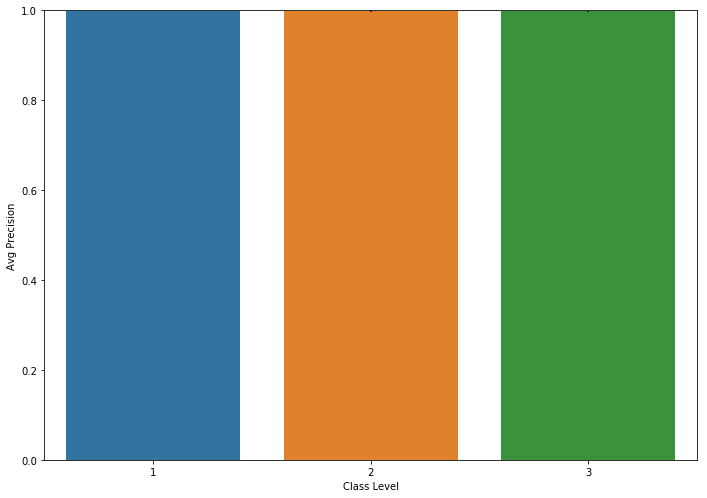

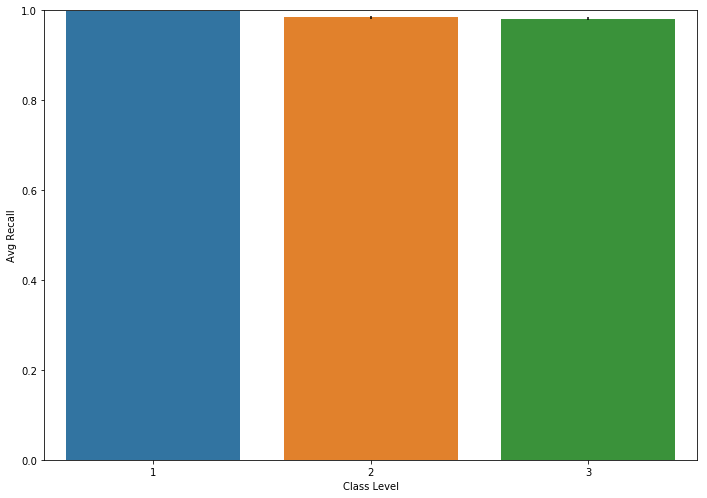

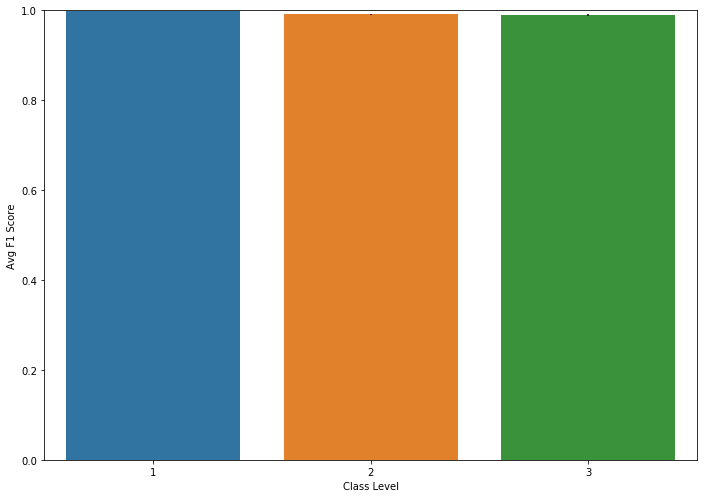

In [9]:
plot_prec(valid_eval_d,acv)
plot_recall(valid_eval_d,acv)
plot_f1(valid_eval_d,acv)

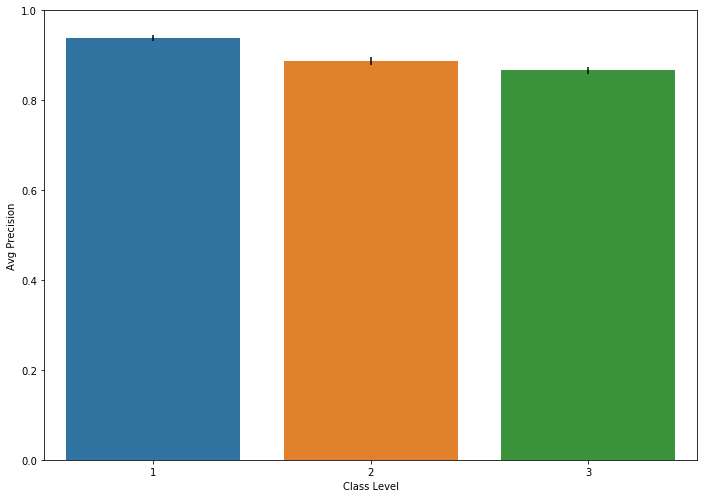

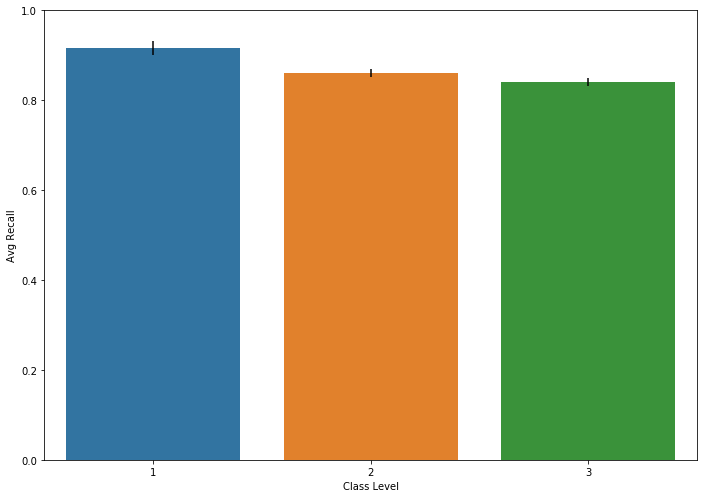

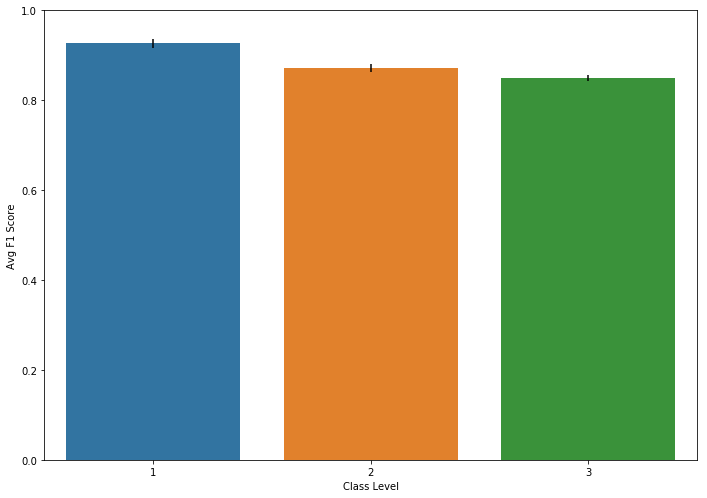

In [10]:
plot_prec(test_eval_d,acv)
plot_recall(test_eval_d,acv)
plot_f1(test_eval_d,acv)

In [24]:
def conf_mat(y,pred, use_log10=False):
    conf_mat = metrics.confusion_matrix(y, pred)
    if use_log10:
        df_cm = pd.DataFrame(np.log10(np.add(conf_mat,1)))
    else:
        df_cm = pd.DataFrame(conf_mat)
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    # sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    sn.heatmap(df_cm)

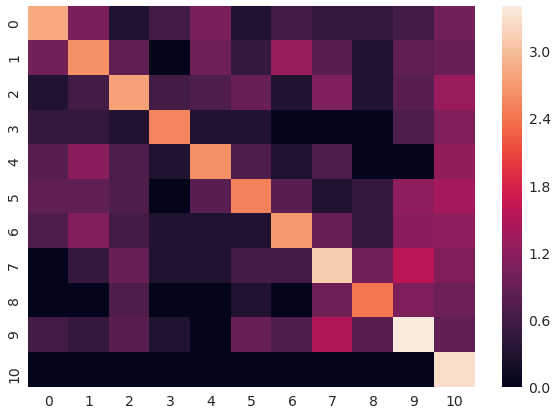

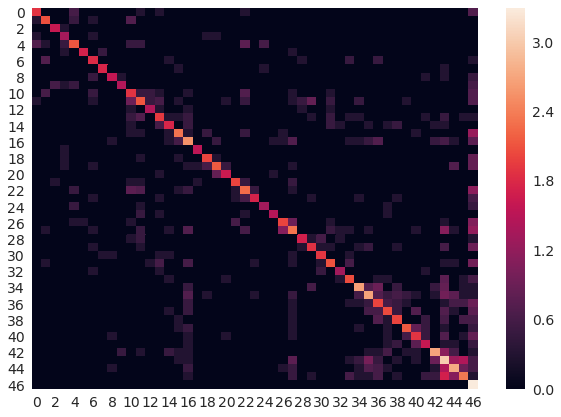

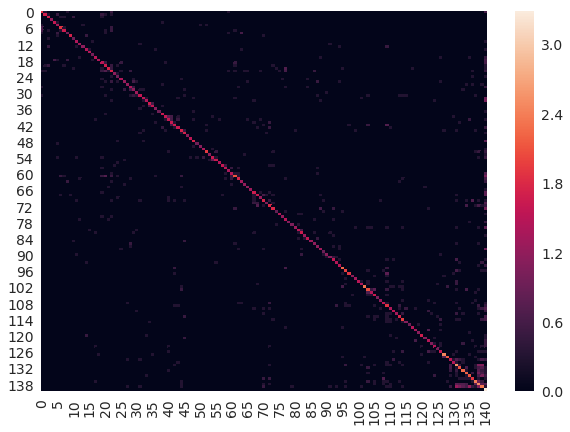

In [25]:
for i in range(1,4):
    conf_mat(test_y_d[i],test_p_d[i], use_log10=True)

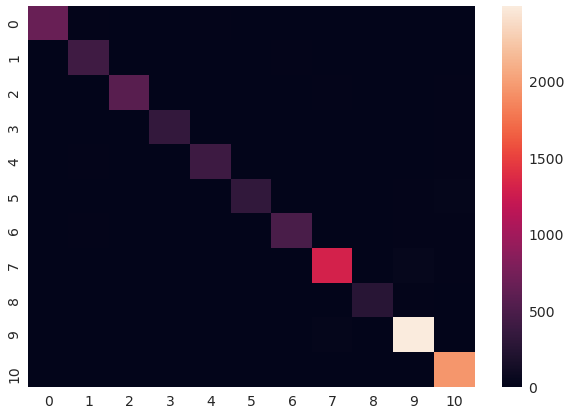

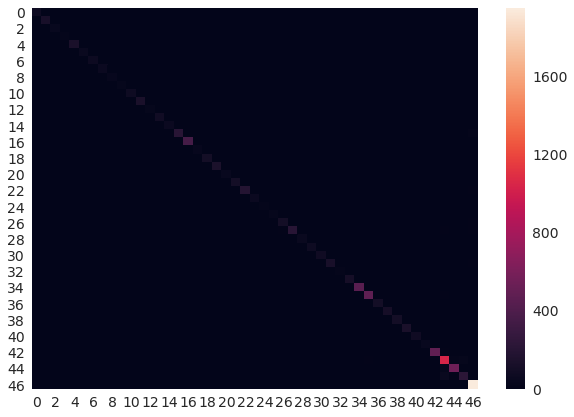

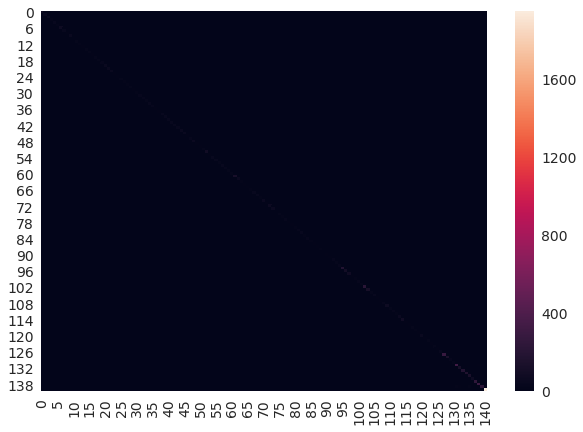

In [26]:
for i in range(1,4):
    conf_mat(test_y_d[i],test_p_d[i], use_log10=False)

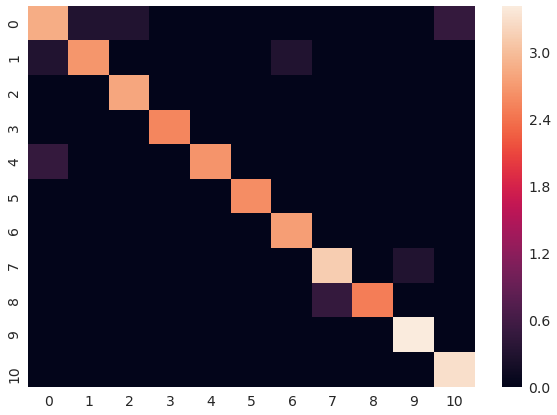

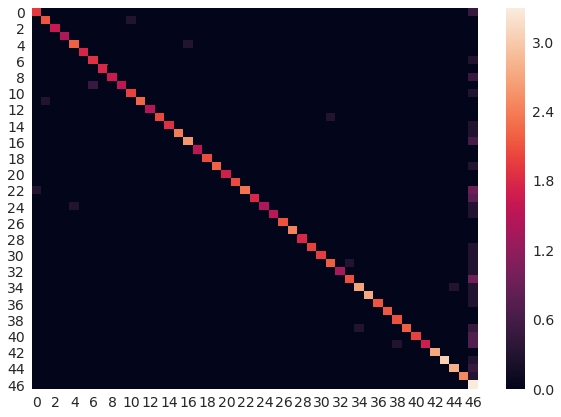

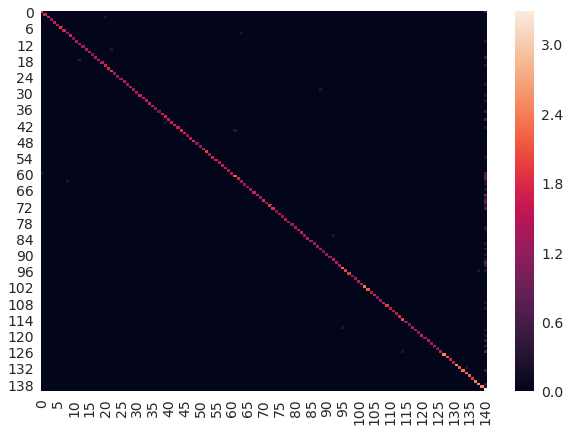

In [27]:
for i in range(1,4):
    conf_mat(valid_y_d[i],valid_p_d[i], use_log10=True)

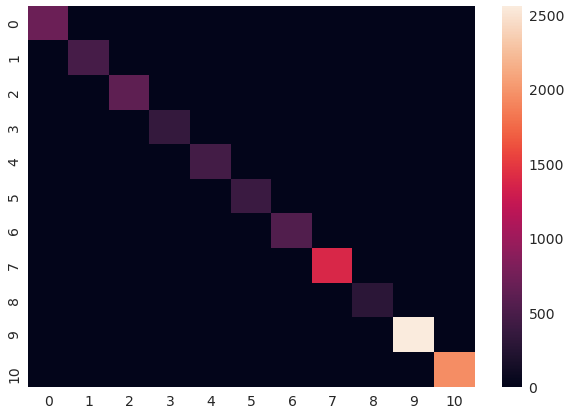

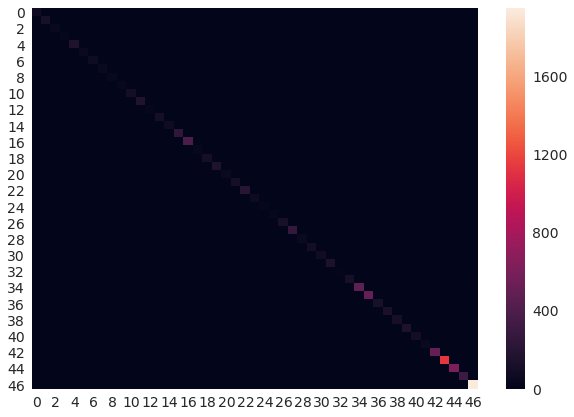

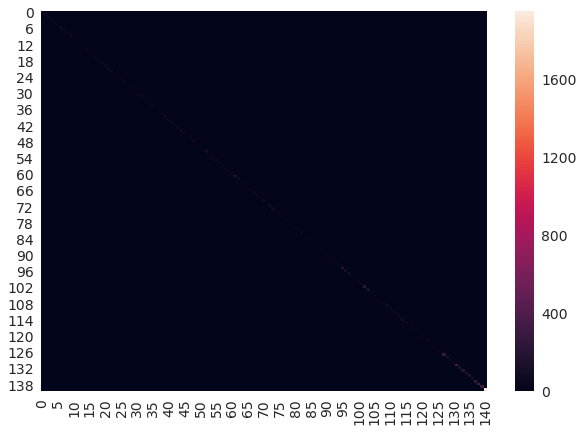

In [28]:
for i in range(1,4):
    conf_mat(valid_y_d[i],valid_p_d[i], use_log10=False)

In [66]:
def class_bars(pred, width, height):
    df = pd.DataFrame()
    df['class'] = pd.Series(pred)
    counts = df['class'].value_counts().sort_values(ascending=True)
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    vplot = sn.countplot(data=df,x='class', ax=ax, order=list(counts.index))

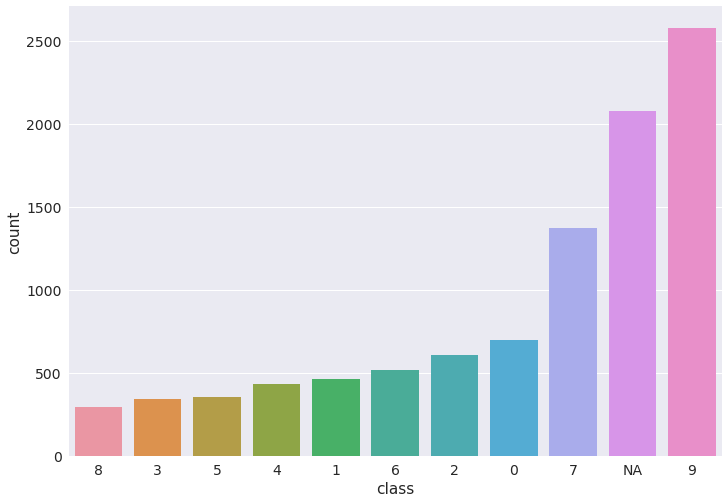

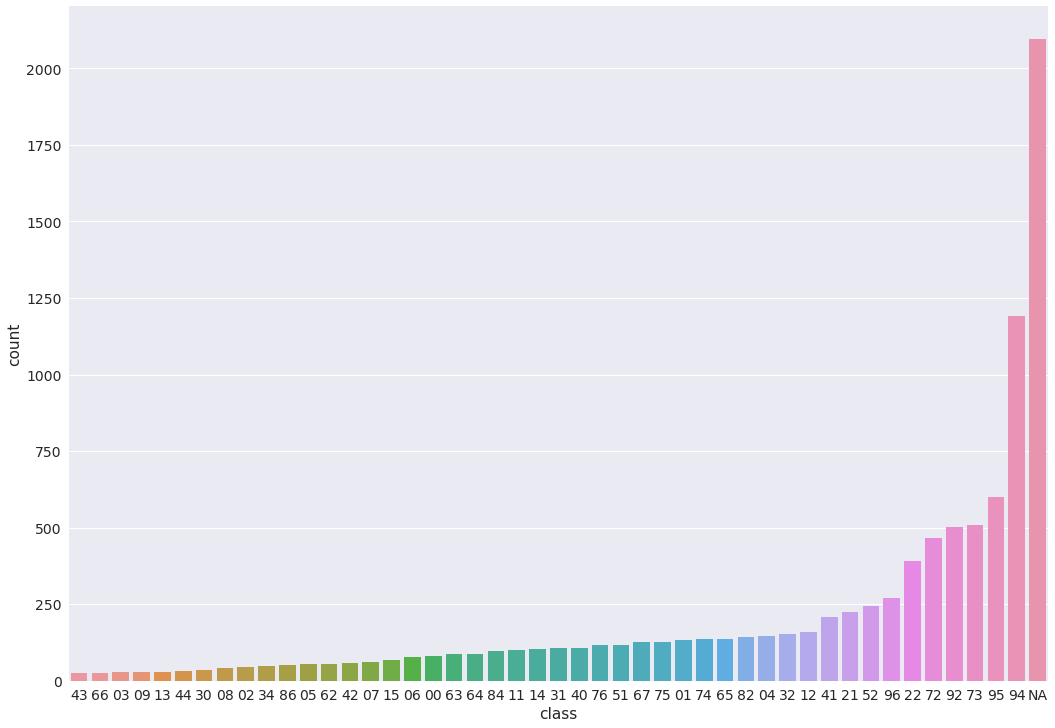

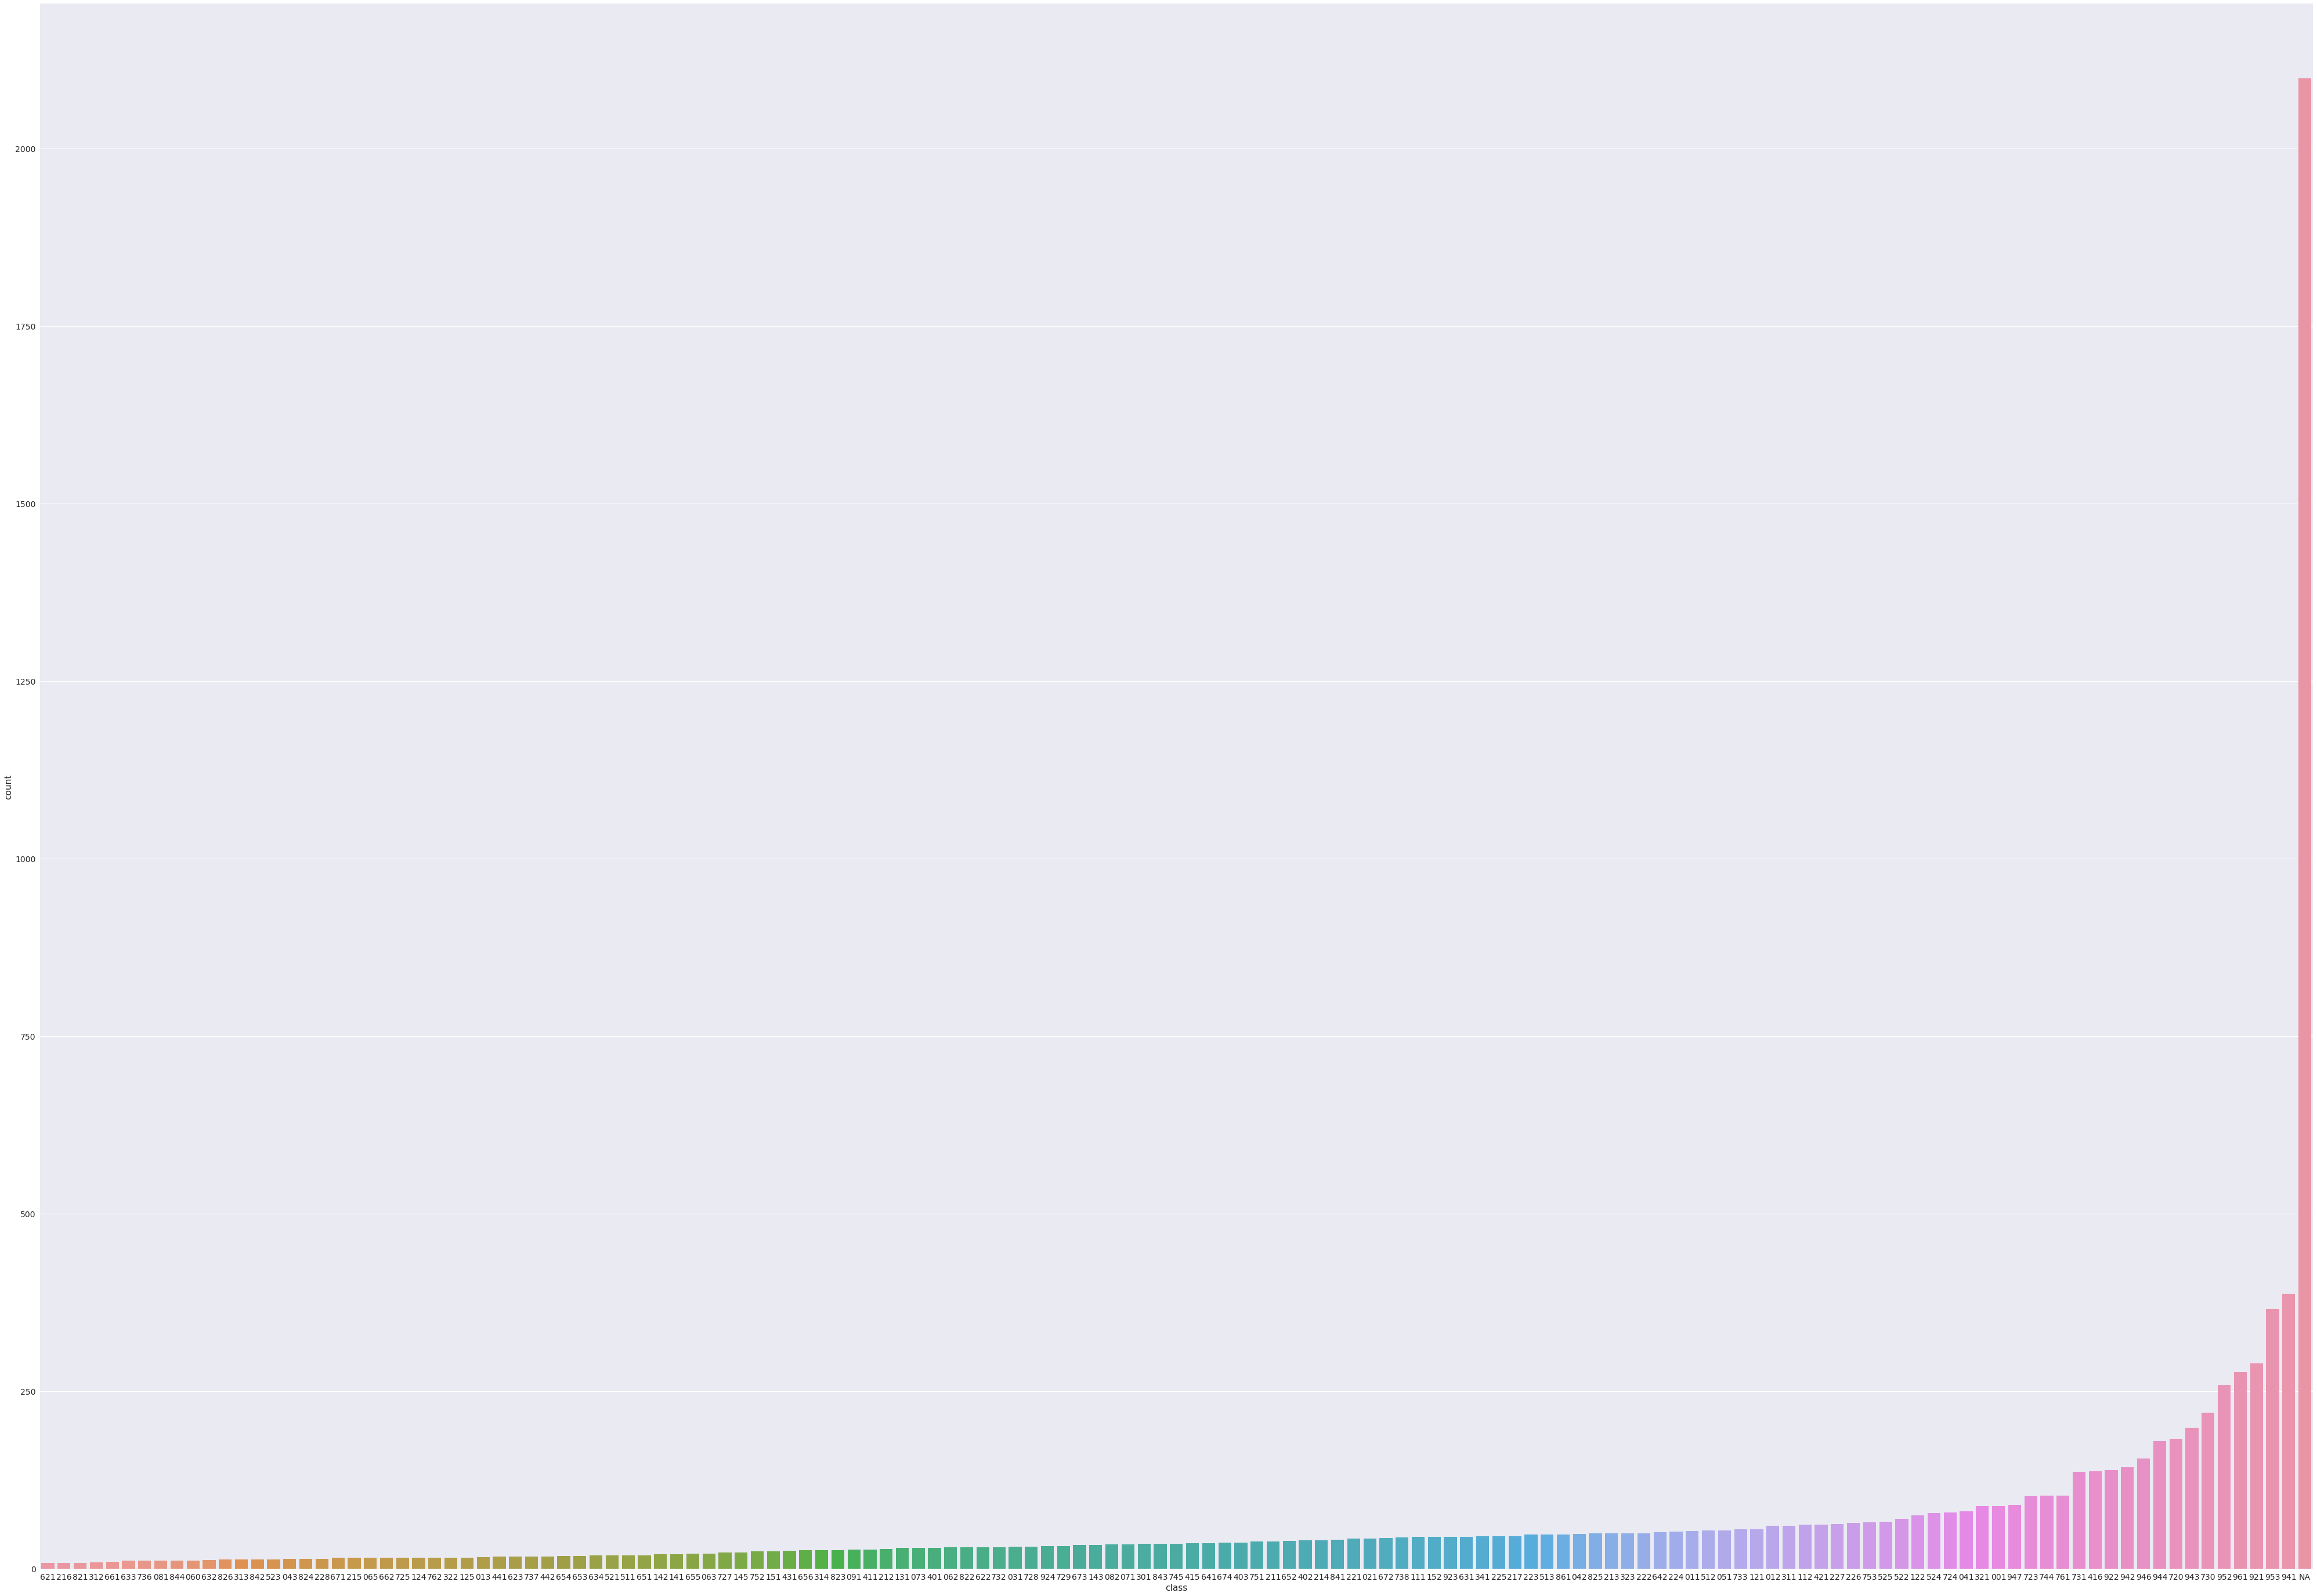

In [71]:
sizes=dict()
sizes[1] = [11.7, 8.27]
sizes[2] = [11.7*1.5, 8.27*1.5]
sizes[3] = [11.7*6, 8.27*6]
for i in range(1,4):
    class_bars(test_p_d[i], sizes[i][0], sizes[i][1])